In [9]:
import numpy as np
import qutip as qt
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
# Setup
cutoff_dim = 10
num_layers = 5
np.random.seed(0)  # for reproducibility
data = np.linspace(-np.pi, np.pi, 50)  # Input data
noise = 0.1 * np.random.randn(50)  # Gaussian noise
noisy_data = data + noise  # Noisy data
target = np.sin(data)  # Target values

In [15]:
# Kerr Gate
def kerr(dim, kappa):
    a = qt.destroy(dim)
    return (1j * kappa * a.dag() * a * a.dag() * a).expm()

def rotate(dim, phi):
    return (-1j * phi * qt.num(dim)).expm()

# Quantum Circuit
def quantum_circuit(params, x):
    psi = qt.displace(cutoff_dim, x) * qt.basis(cutoff_dim, 0)  # Encoding data
    for i in range(num_layers):
        phi1, r, phi2, b, kappa = params[i]
        K = kerr(cutoff_dim, kappa) 
        D = qt.displace(cutoff_dim, b) 
        R2 = rotate(cutoff_dim, phi2) 
        S = qt.squeeze(cutoff_dim, r) 
        R1 = rotate(cutoff_dim, phi1) 
        psi = K*D*R2*S*R1*psi
    return psi

# Cost function
def cost_function(params, data, target):
    loss = 0
    for x, y in zip(data, target):
        final_state = quantum_circuit(params.reshape((num_layers, 5)), x)
        prediction = qt.expect(qt.position(cutoff_dim), final_state)
        loss += (prediction - y)**2
    return loss / len(data)

tf_cost_function = tf.function(
    lambda params: tf.numpy_function(cost_function, [params, noisy_data, target], tf.float64)
)

In [18]:
# Initialize Parameters and Optimizer
train_params = np.random.rand(num_layers, 5)
optimizer = tf.optimizers.Adam()

# Training (Optimization)
for step in tqdm(range(500)):  # assuming 500 optimization steps
    with tf.GradientTape() as tape:
        tape.watch(train_params)
        loss = tf_cost_function(train_params)
    gradients = tape.gradient(loss, train_params)
    optimizer.apply_gradients([(gradients, train_params)])

# Optimized parameters
optimized_params = train_params

Optimization Progress:   2%|▉                                             | 1/50 [00:59<48:50, 59.81s/it, loss=1.2e+12]

KeyboardInterrupt: 

In [5]:
# Evaluation
new_data = np.linspace(-np.pi, np.pi, 50)
predictions = [qt.expect(qt.num(cutoff_dim), quantum_circuit(optimized_params, x)) for x in new_data]

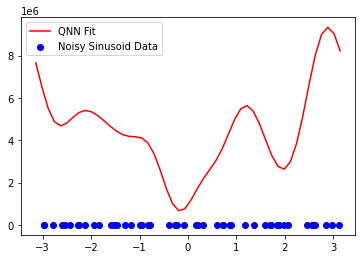

In [6]:
# Plotting the fit
plt.scatter(noisy_data, target, color='blue', label='Noisy Sinusoid Data')
plt.plot(data, predictions, color='red', label='QNN Fit')
plt.legend()
plt.show()